<a 
href="https://colab.research.google.com/github/wingated/cs474_labs_f2019/blob/master/DL_Lab6.ipynb"
  target="_parent">
  <img
    src="https://colab.research.google.com/assets/colab-badge.svg"
    alt="Open In Colab"/>
</a>

# Lab 6: Sequence-to-sequence models

### Description:
For this lab, you will code up the [char-rnn model of Karpathy](http://karpathy.github.io/2015/05/21/rnn-effectiveness/). This is a recurrent neural network that is trained probabilistically on sequences of characters, and that can then be used to sample new sequences that are like the original.

This lab will help you develop several new skills, as well as understand some best practices needed for building large models. In addition, we'll be able to create networks that generate neat text!

### Deliverable:
- Fill in the code for the RNN (using PyTorch's built-in GRU).
- Fill in the training loop
- Fill in the evaluation loop. In this loop, rather than using a validation set, you will sample text from the RNN.
- Implement your own GRU cell.
- Train your RNN on a new domain of text (Star Wars, political speeches, etc. - have fun!)

### Grading Standards:
- 20% Implementation the RNN
- 20% Implementation training loop
- 20% Implementation of evaluation loop
- 20% Implementation of your own GRU cell
- 20% Training of your RNN on a domain of your choice

### Tips:
- Read through all the helper functions, run them, and make sure you understand what they are doing
- At each stage, ask yourself: What should the dimensions of this tensor be? Should its data type be float or int? (int is called `long` in PyTorch)
- Don't apply a softmax inside the RNN if you are using an nn.CrossEntropyLoss (this module already applies a softmax to its input).

### Example Output:
An example of my final samples are shown below (more detail in the
final section of this writeup), after 150 passes through the data.
Please generate about 15 samples for each dataset.

<code>
And ifte thin forgision forward thene over up to a fear not your
And freitions, which is great God. Behold these are the loss sub
And ache with the Lord hath bloes, which was done to the holy Gr
And appeicis arm vinimonahites strong in name, to doth piseling 
And miniquithers these words, he commanded order not; neither sa
And min for many would happine even to the earth, to said unto m
And mie first be traditions? Behold, you, because it was a sound
And from tike ended the Lamanites had administered, and I say bi
</code>


---

## Part 0: Readings, data loading, and high level training

---

There is a tutorial here that will help build out scaffolding code, and get an understanding of using sequences in pytorch.

* Read the following

> * [Pytorch sequence-to-sequence tutorial](https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html) (Take note that you will not be implementing the encoder part of this tutorial.)
* [Understanding LSTM Networks](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)






In [ ]:
# ! wget -O ./text_files.tar.gz 'https://piazza.com/redirect/s3?bucket=uploads&prefix=attach%2Fjlifkda6h0x5bk%2Fhzosotq4zil49m%2Fjn13x09arfeb%2Ftext_files.tar.gz' 
# ! tar -xzf text_files.tar.gz
# ! pip install unidecode
# ! pip install torch

import unidecode
import string
import random
import re
 
import pdb
from tqdm import tqdm
 
all_characters = string.printable
n_characters = len(all_characters)
file = unidecode.unidecode(open('./text_files/lotr.txt').read())
file_len = len(file)
print('file_len =', file_len)
print('n_characters =', n_characters)

file_len = 2579888
n_characters = 100


In [ ]:
string.printable

'0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~ \t\n\r\x0b\x0c'

In [ ]:
chunk_len = 200
 
def random_chunk():
  start_index = random.randint(0, file_len - chunk_len)
  end_index = start_index + chunk_len + 1
  return file[start_index:end_index]
  
print(random_chunk())

am sure. No, something else 
drew him away. So my friends think, those that hunted him for me. 

'The Wood -elves tracked him first, an easy task for them, for his trail 
was still fresh then. Through 


In [ ]:
import torch
# Turn string into list of longs
def char_tensor(string):
  tensor = torch.zeros(len(string)).long()
  for c in range(len(string)):
      tensor[c] = all_characters.index(string[c])
  return tensor

print(char_tensor('abcDEF'))

def tensor_to_string(char_t):
  my_string = ""
  for num in char_t:
    my_string += string.printable[num]

  return my_string

print(tensor_to_string(char_tensor('abcDEF')))

tensor([10, 11, 12, 39, 40, 41])
abcDEF


---

## Part 4: Creating your own GRU cell 

**(Come back to this later - its defined here so that the GRU will be defined before it is used)**

---

The cell that you used in Part 1 was a pre-defined Pytorch layer. Now, write your own GRU class using the same parameters as the built-in Pytorch class does.

Please try not to look at the GRU cell definition. The answer is right there in the code, and in theory, you could just cut-and-paste it. This bit is on your honor!

**TODO:**

**DONE:**
* Create a custom GRU cell



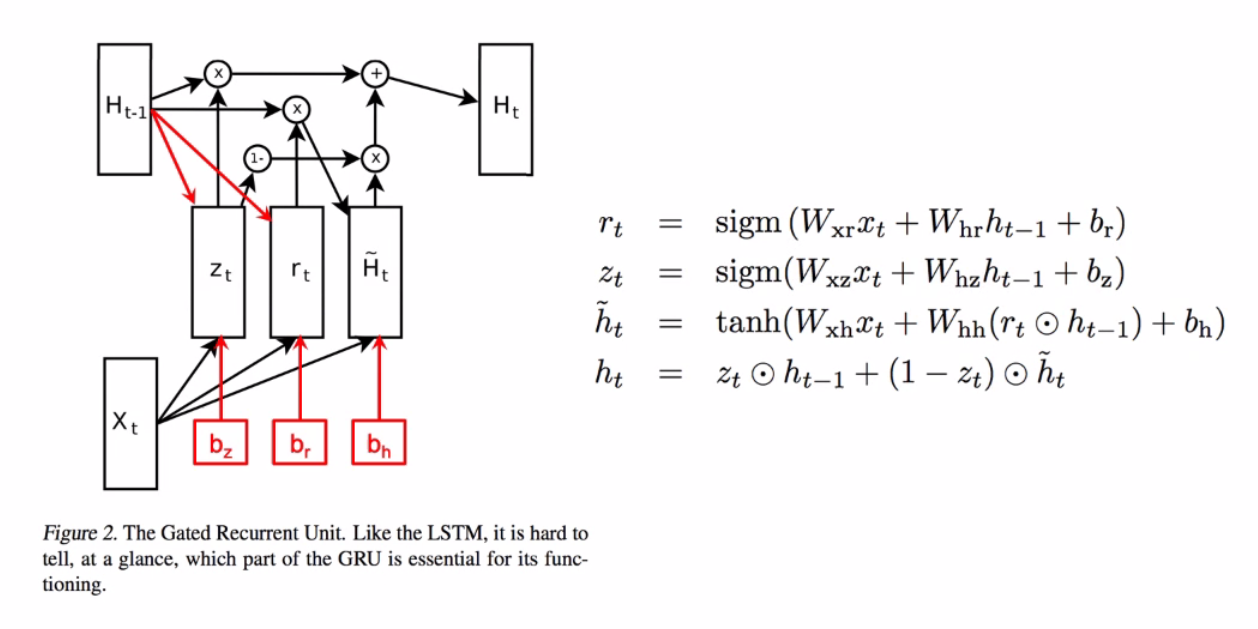

In [ ]:
# Multi-layer GRU should concatenate the hidden states along dim=0 while progressing through the GRU cells
# the concatenated hidden layers get returned from the GRU so that they can be passed the next iteration

import torch
import torch.nn as nn
import torch.nn.functional as F


class GRU(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers):
    super(GRU, self).__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    
    self.W_xr = nn.Linear(self.input_size, self.hidden_size)
    self.W_xz = nn.Linear(self.input_size, self.hidden_size)
    self.W_xh = nn.Linear(self.input_size, self.hidden_size)
    self.W_hr = nn.Linear(self.hidden_size, self.hidden_size)
    self.W_hz = nn.Linear(self.hidden_size, self.hidden_size)
    self.W_hh = nn.Linear(self.hidden_size, self.hidden_size)

    self.sig = nn.Sigmoid()
    self.tanh = nn.Tanh()
    
  # inputs: [1, 1, input_size]       ~     [1, 1, 100]
  # hidden: [num_layers, 1, hidden_size] ~ [3, 1, 200]
  def forward(self, inputs, hidden):
    # Each layer does the following:
    # r_t = sigmoid(W_ir*x_t + b_ir + W_hr*h_(t-1) + b_hr)
    # z_t = sigmoid(W_iz*x_t + b_iz + W_hz*h_(t-1) + b_hz)
    # n_t = tanh(W_in*x_t + b_in + r_t**(W_hn*h_(t-1) + b_hn))
    # h_(t) = (1 - z_t)**n_t + z_t**h_(t-1)
    # Where ** is hadamard product (not matrix multiplication, but elementwise multiplication)

    b_r = torch.rand(1, 1, self.hidden_size)
    b_z = torch.rand(1, 1, self.hidden_size)
    b_h = torch.rand(1, 1, self.hidden_size)
    old_h = hidden[-1]

    hiddens = torch.zeros(self.num_layers, 1, self.hidden_size)

    for i in range(self.num_layers):
      r_t = self.sig(self.W_xr(inputs) + self.W_hr(old_h) + b_r)
      z_t = self.sig(self.W_xz(inputs) + self.W_hz(old_h) + b_z)
      n_t = self.tanh(self.W_xh(inputs) + self.W_hh(old_h*r_t) + b_h)
      h_t = z_t*old_h + (1-z_t)*n_t
      hiddens[i] = h_t
      old_h = h_t
    
    # outputs: [1, 1, hidden_size]      ~     [1, 1, 200]
    # hiddens: [num_layers, 1, hidden_size] ~ [3, 1, 200]
    return h_t, hiddens
  

---

##  Part 1: Building a sequence to sequence model

---

Great! We have the data in a useable form. We can switch out which text file we are reading from, and trying to simulate.

We now want to build out an RNN model, in this section, we will use all built in Pytorch pieces when building our RNN class.


**TODO:**

**DONE:**
* Create an RNN class that extends from nn.Module.



In [ ]:
# OUTSIDE
# output, hidden = RNN(input_char, hidden_state)
# INSIDE
# character -> embedding_process -> INPUT
# size(INPUT) == size(hidden_state)
# GRU(INPUT, hidden_state)

class RNN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size, n_layers=1):
    super(RNN, self).__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.output_size = output_size
    self.n_layers = n_layers
    
    # more stuff here...
    self.embedding = nn.Embedding(output_size, input_size)
    self.gru = GRU(input_size, hidden_size, n_layers)
    self.out = nn.Linear(hidden_size, output_size)

  def forward(self, input_char, hidden):
    # by reviewing the documentation, construct a forward function that properly uses the output
    # of the GRU

    # stuff here
    output = self.embedding(input_char).view(1, 1, -1)
    output = F.relu(output)
    output, hidden = self.gru(output, hidden)
    output = self.out(output[0])

    return output, hidden

  def init_hidden(self):
    return torch.zeros(self.n_layers, 1, self.hidden_size)

In [ ]:
def random_training_set():    
  chunk = random_chunk()
  inp = char_tensor(chunk[:-1])
  target = char_tensor(chunk[1:])
  return inp, target

---

## Part 2: Sample text and Training information

---

We now want to be able to train our network, and sample text after training.

This function outlines how training a sequence style network goes. 

**TODO:**

**DONE:**
* Fill in the pieces.




In [ ]:
# OUTSIDE
# train(input_string, target_string)
# INSIDE
# init_hidden_state( tensor of all zeros )
# loop through input, aggregate loss each step
# backprop and step

# NOTE: decoder_optimizer, decoder, and criterion will be defined below as global variables
def train(inp, target):
  ## initialize hidden layers, set up gradient and loss 
    # your code here
  ## /

  decoder_optimizer.zero_grad()
  hidden = decoder.init_hidden()
  loss = 0

  for i in range(inp.size(0)):
    output, hidden = decoder(inp[i], hidden)
    # output -= output.min(1, keepdim=True)[0]
    # output /= output.max(1, keepdim=True)[0]
    # output = torch.multinomial(output, 1)
    # pdb.set_trace()
    loss += criterion(output.float(), target[i].view(1))
    
  # more stuff here...
  loss.backward()
  decoder_optimizer.step()

  return loss.item() / chunk_len

---

## Part 3: Sample text and Training information

---

You can at this time, if you choose, also write out your train loop boilerplate that samples random sequences and trains your RNN. This will be helpful to have working before writing your own GRU class.

If you are finished training, or during training, and you want to sample from the network you may consider using the following function. If your RNN model is instantiated as `decoder`then this will probabilistically sample a sequence of length `predict_len`

**TODO:**

**DONE:**
* Fill out the evaluate function to generate text frome a primed string



In [ ]:
# OUTSIDE
# Evaluate(prime_str, predict_len, temperature)
# INSIDE
# build up a hidden state by starting at the beginning of the prime_str
# predict future characters by sampling from the output vector

def sample_outputs(output, temperature):
    """Takes in a vector of unnormalized probability weights and samples a character from the distribution"""
    return torch.multinomial(torch.exp(output / temperature), 1)

def evaluate(prime_str='A', predict_len=100, temperature=0.8):
  ## initialize hidden state, initialize other useful variables
    # your code here
  ## /

  hidden = decoder.init_hidden()

  prime_str = char_tensor(prime_str)
  final_str = prime_str

  with torch.no_grad():
    for i in range(len(prime_str)):
      output, hidden = decoder(prime_str[i], hidden)
    for i in range(predict_len):
      output, hidden = decoder(final_str[-1], hidden)
      # pdb.set_trace()
      final_str = torch.cat((final_str, sample_outputs(output, temperature).squeeze(0)))
      # final_str.append(sample_outputs(output, temperature))

  return tensor_to_string(final_str)


---

## Part 4: (Create a GRU cell, requirements above)

---



---

## Part 5: Run it and generate some text!

---


**TODO:** 

**DONE:**
* Create some cool output




Assuming everything has gone well, you should be able to run the main function in the scaffold code, using either your custom GRU cell or the built in layer, and see output something like this. I trained on the “lotr.txt” dataset, using chunk_length=200, hidden_size=100 for 2000 epochs. These are the results, along with the prime string:

---

 G:
 
 Gandalf was decrond. 
'All have lord you. Forward the road at least walk this is stuff, and 
went to the long grey housel-winding and kindled side was a sleep pleasuring, I do long 
row hrough. In  

 lo:
 
 lost death it. 
'The last of the gatherings and take you,' said Aragorn, shining out of the Gate. 
'Yes, as you there were remembaused to seen their pass, when? What 
said here, such seven an the sear 

 lo:
 
 low, and frod to keepn 
Came of their most. But here priced doubtless to an Sam up is 
masters; he left hor as they are looked. And he could now the long to stout in the right fro horseless of 
the like 

 I:
 
 I had been the 
in his eyes with the perushed to lest, if then only the ring and the legended 
of the less of the long they which as the 
enders of Orcovered and smood, and the p 

 I:
 
 I they were not the lord of the hoomes. 
Home already well from the Elves. And he sat strength, and we 
housed out of the good of the days to the mountains from his perith. 

'Yess! Where though as if  

 Th:
 
 There yarden 
you would guard the hoor might. Far and then may was 
croties, too began to see the drumbred many line 
and was then hoard walk and they heart, and the chair of the 
Ents of way, might was 

 G:
 
 Gandalf 
been lat of less the round of the stump; both and seemed to the trees and perished they 
lay are speered the less; and the wind the steep and have to she 
precious. There was in the oonly went 

 wh:
 
 which went out of the door. 
Hull the King and of the The days of his brodo 
stumbler of the windard was a thing there, then it been shining langing 
to him poor land. They hands; though they seemed ou 

 ra:
 
 rather,' have all the least deather 
down of the truven beginning to the house of sunk. 
'Nark shorts of the Eyes of the Gate your great nothing as Eret. 
'I wander trust horn, and there were not, it  

 I:
 
 I can have no mind 
together! Where don't may had one may little blung 
terrible to tales. And turn and Gandalf shall be not to as only the Cattring 
not stopped great the out them forms. On they she lo 

---


In [ ]:
import time
n_epochs = 5000
print_every = 250  # 200
plot_every = 25
hidden_size = 200
n_layers = 3
lr = 0.001

decoder = RNN(n_characters, hidden_size, n_characters, n_layers)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
loss_avg = 0

In [ ]:
# n_epochs = 2000
for epoch in range(1, n_epochs + 1):
  loss_ = train(*random_training_set())       
  loss_avg += loss_

  if epoch % print_every == 0:
      print('[%s (%d %d%%) %.4f]' % (time.time() - start, epoch, epoch / n_epochs * 100, loss_))
      print(evaluate('Wh', 100), '\n')

  if epoch % plot_every == 0:
      all_losses.append(loss_avg / plot_every)
      loss_avg = 0

[227.65393447875977 (250 5%) 2.0587]
Wher noustes pabler nhic an fore ales he, of fad mout ca uns drount al of ave nor as hild and the 


I 

[454.6832482814789 (500 10%) 2.0219]
Whed the had sip, you Grat of hat weaver the in wat 
pobdery beeant, of all and 
leap werped to breire 

[679.5691349506378 (750 15%) 2.0152]
Whirs therey the mandot notanay s
calves, and 
with 
the sparong tare the Oresing mime, and for apoup  

[905.4836609363556 (1000 20%) 1.9586]
Why rowes in the Ime yunder. 

The hid the strufpet: and 
the his wow anther thise the Ever fol' to li 

[1131.2858169078827 (1250 25%) 1.7373]
Wh the wornelf, the Eandrer of the reace to 
an far too stillgon though frido, do the wink. 
'Frodo, w 

[1356.9663105010986 (1500 30%) 1.7869]
What?' said apit in not seen 
felles upone, in the gorow 
amaming the wite in the Could and they gards 

[1581.2604608535767 (1750 35%) 1.8923]
What your untles for that geefinging are forth get song a finking of 
have on mortil for had stong, an 


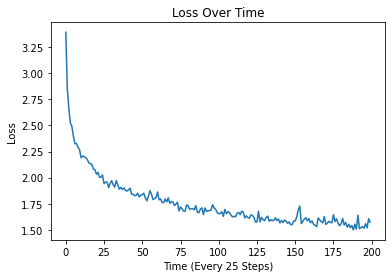

In [ ]:
import matplotlib.pyplot as plt

plt.plot(all_losses)
plt.xlabel("Time (Every 25 Steps)")
plt.ylabel("Loss")
plt.title("Loss Over Time")
plt.show()

In [ ]:
for i in range(10):
  start_strings = [" Th", " wh", " he", " I ", " ca", " G", " lo", " ra"]
  start = random.randint(0,len(start_strings)-1)
  print(start_strings[start])
#   all_characters.index(string[c])
  print(evaluate(start_strings[start], 200), '\n')

 wh
 where is on the botto about 



Chillen and it in it lie cold allum and the pases and on a left Mores,' 

'A we shall to to be the should the hressing were to. 

At for it and age for he give on or fear 

 G
 Gimli. 'And three 
far of the worlden of the Shire now seemy at the horse. 

It says of Gried. The reen of our and the oursenly beyond out or 
crees of Moromir and Merry mark thought the lord and to wi 

 ca
 caking and 
can purpter have? ' he sapn 



Summen rear way. But the reewhage were were get fage some the other 
eever in the sunnern, and you were now, and I yet more over the Shire over the 
voued exp 

 wh
 white they had not has face 
them of the great skin for Shread. 'Whe trie threemen of the Mordor the saider to a presed on the 
Cord Aragon for the grew as anoth their keep of the Company rest here, 
so 

 he
 her we shill come them 
yet with the Ent. I will the could near in the 
road is yet. Then far hopped that,' 

'What with footh of it halms of come the stood 

---

## Part 6: Generate output on a different dataset

---

**TODO:**

**DONE:**

* Choose a textual dataset. Here are some [text datasets](https://www.kaggle.com/datasets?tags=14104-text+data%2C13205-text+mining) from Kaggle 

* Generate some decent looking results and evaluate your model's performance (say what it did well / not so well)



In [ ]:
file = unidecode.unidecode(open('./text_files/alma.txt').read())
file_len = len(file)
# file = unidecode.unidecode(open('./text_files/lotr.txt').read())

decoder = RNN(n_characters, hidden_size, n_characters, n_layers)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)

start = time.time()
all_losses = []
loss_avg = 0

for epoch in range(1, n_epochs + 1):
  loss_ = train(*random_training_set())       
  loss_avg += loss_

  if epoch % print_every == 0:
      print('[%s (%d %d%%) %.4f]' % (time.time() - start, epoch, epoch / n_epochs * 100, loss_))
      print(evaluate('Wh', 100), '\n')

  if epoch % plot_every == 0:
      all_losses.append(loss_avg / plot_every)
      loss_avg = 0

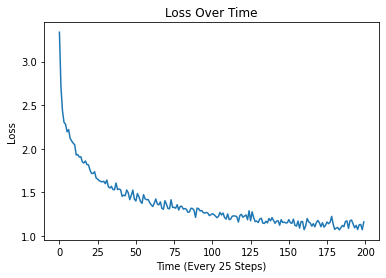

In [ ]:
import matplotlib.pyplot as plt

plt.plot(all_losses)
plt.xlabel("Time (Every 25 Steps)")
plt.ylabel("Loss")
plt.title("Loss Over Time")
plt.show()

In [ ]:
for i in range(10):
  start_strings = [" Th", " wh", " he", " I ", " ca", " G", " lo", " ra"]
  start = random.randint(0,len(start_strings)-1)
  print(start_strings[start])
#   all_characters.index(string[c])
  print(evaluate(start_strings[start], 200), '\n')

 wh
 which have the thou angries of the earth, that ye shall retained unto the Lamanites ansolek; therefore this shall be the people of God; and those are man do not gained the Nephites which thousand that t 

 wh
 which had power of the judge of the power of Modoni, hath being to the souls of the city of Mod to go once that their subsements, that they do song the Zoramites them.

 And the Zare ye God of war of th 

 wh
 which is is three come to pass that the Lamanites, and the prossit of the law, yea, and also come so preach that Ammon; yea, my come many be into the power, and said them that prophed to enter his pross 

 he
 hep Zorami, by the spirit.

 And now, is it hath puapt of the Lord after the people of Nephi, before he did fevertheless were the people, that the faith of the Amulon; and they were stand, and Modion in 

 lo
 lod, miven into the seed not preach.

 And I having afflict buth of thy returned.

 And it came to pass deass to estaplemnall by the land of Anti-Nelent, w